In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read in individual datasets for each state
all_states = os.listdir('clean_data/')
all_states = {f[:2]:pd.read_csv(f"clean_data/{f}") for f in all_states if len(f)<7}
print("Total number of states (including Federal Bureau of Prisons):", len(all_states.keys()))
all_states['MA']

Total number of states (including Federal Bureau of Prisons): 51


,name,abbreviation,staff_tests,prisoner_tests,total_staff_cases,total_prisoner_cases,total_staff_deaths,total_prisoner_deaths,date,week_num
0,Massachusetts,MA,NaN,NaN,4.0,9.0,0.0,0.0,2020-03-26,2020-13
1,Massachusetts,MA,NaN,NaN,7.0,20.0,0.0,0.0,2020-04-01,2020-14
2,Massachusetts,MA,NaN,NaN,26.0,46.0,0.0,3.0,2020-04-08,2020-15
3,Massachusetts,MA,NaN,NaN,42.0,90.0,0.0,4.0,2020-04-15,2020-16
4,Massachusetts,MA,NaN,296.0,93.0,127.0,0.0,7.0,2020-04-22,2020-17
5,Massachusetts,MA,NaN,747.0,120.0,257.0,0.0,7.0,2020-04-29,2020-18
6,Massachusetts,MA,NaN,1906.0,151.0,351.0,0.0,7.0,2020-05-06,2020-19


In [3]:
# Read in population data and fillna using OLS
pop = pd.read_csv('clean_data/population.csv')

# Fillin the nan values using a linear model
from sklearn.linear_model import LinearRegression
train = pop[pop['staff_pop']>0].copy()
test = pop[pop['staff_pop'].isna()].copy()
X_train, X_test, y_train = train[['prison_pop']], test[['prison_pop']], train['staff_pop']
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
y_pred = list(map(int, y_pred))
pop.loc[pop['staff_pop'].isnull(), 'staff_pop'] = y_pred
assert pop.isna().sum()['staff_pop'] == 0

### 1.Define 2 types of targets for OLS

In [4]:
# Define 2 types of targets for OLS
# 1. Percentage (in %) of for most recent cumulative prisoner/staff cases over prisoner/staff population
# 2. The slope of cumulative prisoner/staff cases

state_names = [c for c in list(all_states.keys()) if 'US' not in c]
result = {'state':[], 'prison_perc':[], 'staff_perc':[], 'prison_slope':[], 'staff_slope':[]}

for state in state_names:
    result['state'].append(state)
    state_df = all_states[state]
    # Normalize cases by population
    prisoner_pop = pop[pop['abbreviation'] == state]['prison_pop'].values[0]
    staff_pop = pop[pop['abbreviation'] == state]['staff_pop'].values[0]
    state_df['total_prisoner_cases'] /= prisoner_pop
    state_df['total_staff_cases'] /= staff_pop
    
    result['prison_perc'].append(state_df['total_prisoner_cases'].max() * 100)
    result['staff_perc'].append(state_df['total_staff_cases'].max() * 100)
    prison_slope = (state_df['total_prisoner_cases'].max() - state_df['total_prisoner_cases'].min()) / 7
    staff_slope = (state_df['total_staff_cases'].max() - state_df['total_staff_cases'].min()) / 7
    result['prison_slope'].append(prison_slope)
    result['staff_slope'].append(staff_slope)
result = pd.DataFrame(result)
result.head()

,state,prison_perc,staff_perc,prison_slope,staff_slope
0,MN,0.960982,2.164066,0.001373,0.003092
1,AZ,0.165571,0.609185,0.000237,0.000000
2,WA,0.141593,0.397456,0.000202,0.000503
3,WV,0.000000,0.066401,0.000000,0.000095
4,AL,0.037818,0.271609,0.000054,0.000365


### Policy data preprocessing

In [5]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [6]:
df_policy = pd.read_csv("data/policy_data.csv")
df_policy['state'] = df_policy['state'].map(lambda x: us_state_abbrev[x])
df_policy.head()

,state,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,Screening_admissions,Suspended_Transfers,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities
0,AL,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN
1,AK,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,AZ,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
3,AR,1,1,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA,1,1,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [7]:
df_policy = df_policy.fillna(0)
df_policy.describe()

,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,Screening_admissions,Suspended_Transfers,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.780000,0.680000,0.460000,0.520000,0.940000,0.360000,0.360000,0.740000,0.880000,0.580000,0.340000,0.320000,0.520000,0.320000,0.100000,0.100000,0.080000
std,0.418452,0.471212,0.503457,0.504672,0.239898,0.484873,0.484873,0.443087,0.328261,0.498569,0.478518,0.471212,0.504672,0.471212,0.303046,0.303046,0.274048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
dataset = df_policy.merge(result, on=['state'])
dataset.head()

,state,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,...,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities,prison_perc,staff_perc,prison_slope,staff_slope
0,AL,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.037818,0.271609,0.000054,0.000365
1,AK,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.020012,0.405885,0.000029,0.000580
2,AZ,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.165571,0.609185,0.000237,0.000000
3,AR,1,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.192234,3.139679,0.007417,0.004485
4,CA,1,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.335961,0.367391,0.000479,0.000497


In [9]:
x_state = dataset.iloc[:,:-4]

y_prison_perc = dataset['prison_perc']
y_staff_perc = dataset['staff_perc']
y_prison_slope = dataset['prison_slope']
y_staff_slope = dataset['staff_slope']

### 2.EDA on Policy

([<matplotlib.axis.XTick at 0x1a1e31a490>,
 <a list of 17 Text xticklabel objects>)

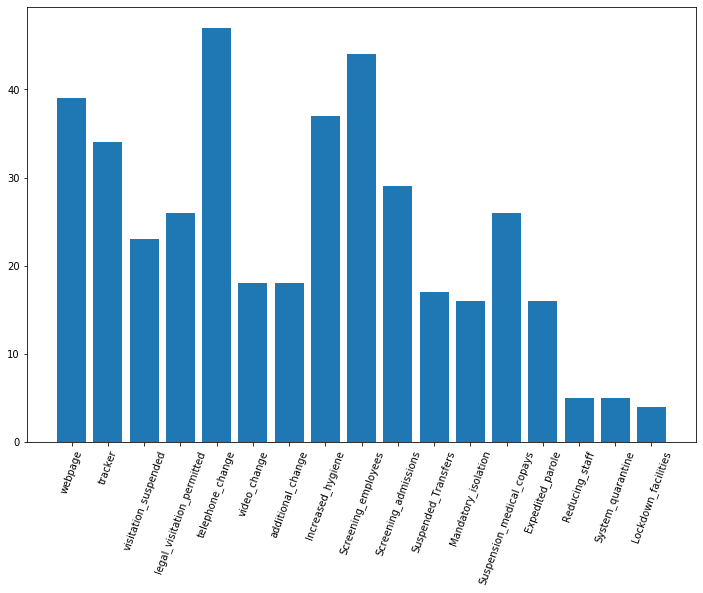

In [10]:
X_data = x_state.drop(['state'], axis=1)

count = []
for x in X_data:
    count.append(sum(X_data[x]))

plt.figure(figsize=(12,8))
plt.bar(range(len(X_data.columns.values)), count)
plt.xticks(range(len(X_data.columns.values)), list(X_data.columns.values), rotation=70)

### 3.Calculate VIF for colinearity

In [11]:
dataset_no_state = dataset.drop(['state'], axis=1)
features_list = list(dataset_no_state.columns)
features_list.remove('prison_perc')
features = "+".join(features_list)

# get y and X dataframes based on this regression:
y_matrix, x_matrix = dmatrices('prison_perc ~' + features, dataset_no_state, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_matrix.values, i) for i in range(x_matrix.shape[1])]
vif["features"] = x_matrix.columns

In [12]:
vif.round(3)

,VIF Factor,features
0,53.155,Intercept
1,1.823,webpage
2,1.602,tracker
3,22.096,visitation_suspended
4,21.371,legal_visitation_permitted
5,2.486,telephone_change
6,1.394,video_change
7,1.378,additional_change
8,1.770,Increased_hygiene
9,1.656,Screening_employees


### Check relationship of target variables

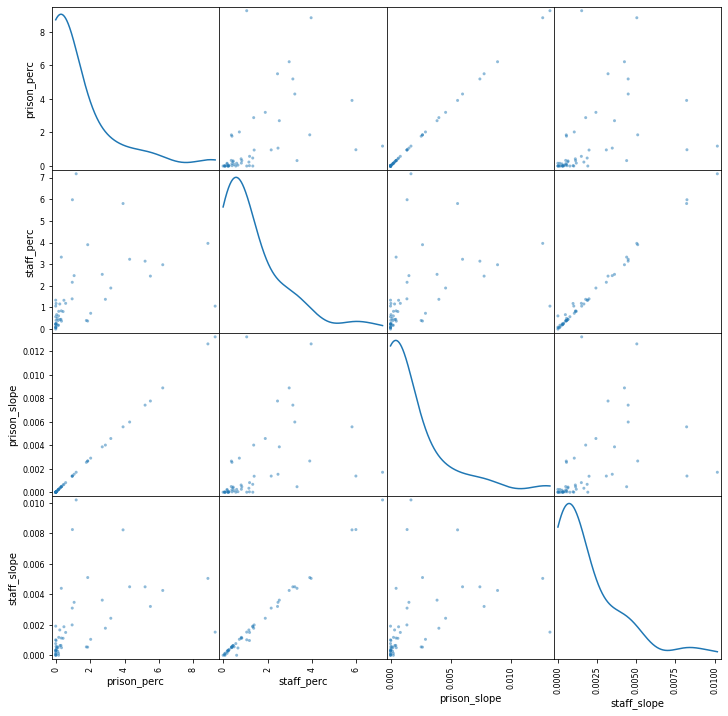

In [13]:
from pandas.plotting import scatter_matrix

y_variables = dataset.iloc[:,18:]
scatter_matrix(y_variables, figsize=(12,12), diagonal='kde')
plt.show()

## 4.OLS - linear regression

In [14]:
# E_x1 = x[y_prison_perc == 1].mean()
# E_x0 = x[y_prison_perc == 0].mean()
# V_x1 = x[y_prison_perc == 1].var()
# V_x0 = x[y_prison_perc == 0].var()
# n1 = len(x[y_prison_perc == 1])
# n0 = len(x[y_prison_perc == 0])
# t_value = abs(E_x1 - E_x0) / np.sqrt(V_x1/n1 + V_x0/n0)

In [15]:
# best_predictor = t_value.sort_values(ascending=False)[:10].index.values
# print("10 top discriminate polices:")
# for p in best_predictor:
#     print(p, end=' ')

In [16]:
X = sm.add_constant(X_data)
linear_regression1 = sm.OLS(y_prison_perc,X)
res1 = linear_regression1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            prison_perc   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                 -0.250
Method:                 Least Squares   F-statistic:                    0.4232
Date:                Fri, 15 May 2020   Prob (F-statistic):              0.968
Time:                        21:58:01   Log-Likelihood:                -105.64
No. Observations:                  50   AIC:                             247.3
Df Residuals:                      32   BIC:                             281.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.8858      2.502      1.153      0.257      -2.211       7.982
webpage                       -0.2900      1.118     -0.259      0.797      -2.567       1.987
tracker                        0.4225      0.948      0.445      0.659      -1.509       2.354
visitation_suspended          -1.5441      3.266     -0.473      0.640      -8.196       5.108
legal_visitation_permitted    -1.3801      3.192     -0.432      0.668      -7.882       5.122
telephone_change              -0.7708      2.264     -0.340      0.736      -5.382       3.841
video_change                   0.8548      0.851      1.005      0.322      -0.878       2.587
additional_change              0.5206      0.859      0.606      0.549      -1.229       2.270
Increased_hygiene              0.6362      1.048      0.607      0.548      -1.498       2.770
Screening_employees            0.6236      1.332      0.468      0.643      -2.090       3.338
Screening_admissions          -0.0701      1.002     -0.070      0.945      -2.112       1.972
Suspended_Transfers           -1.0354      0.911     -1.136      0.264      -2.891       0.821
Mandatory_isolation            0.0737      1.153      0.064      0.949      -2.276       2.423
Suspension_medical_copays      0.0235      0.792      0.030      0.977      -1.590       1.637
Expedited_parole              -1.4808      0.940     -1.575      0.125      -3.396       0.435
Reducing_staff                -0.4670      1.370     -0.341      0.735      -3.258       2.324
System_quarantine             -0.2100      1.458     -0.144      0.886      -3.181       2.761
Lockdown_facilities           -0.3958      1.563     -0.253      0.802      -3.579       2.787
==============================================================================
Omnibus:                       24.109   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.730
Skew:                           1.591   Prob(JB):                     6.41e-09
Kurtosis:                       5.827   Cond. No.                         36.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### After feature selection

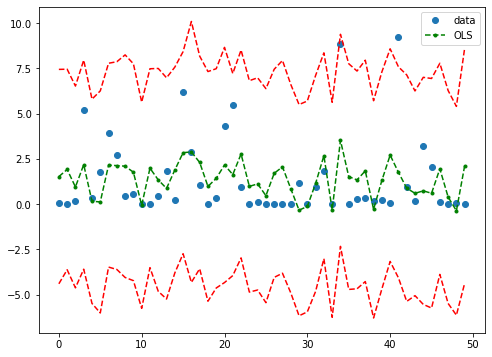

In [17]:
prstd, iv_l, iv_u = wls_prediction_std(res1)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(y_prison_perc, 'o', label="data")
ax.plot(res1.fittedvalues, 'g--.', label="OLS")
ax.plot(iv_u, 'r--')
ax.plot(iv_l, 'r--')
ax.legend(loc='best');

In [18]:
linear_regression2 = sm.OLS(y_prison_slope,X)
res2 = linear_regression2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           prison_slope   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                 -0.252
Method:                 Least Squares   F-statistic:                    0.4202
Date:                Fri, 15 May 2020   Prob (F-statistic):              0.969
Time:                        21:58:01   Log-Likelihood:                 222.01
No. Observations:                  50   AIC:                            -408.0
Df Residuals:                      32   BIC:                            -373.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0040      0.004      1.125      0.269      -0.003       0.011
webpage                       -0.0004      0.002     -0.258      0.798      -0.004       0.003
tracker                        0.0006      0.001      0.446      0.658      -0.002       0.003
visitation_suspended          -0.0022      0.005     -0.466      0.645      -0.012       0.007
legal_visitation_permitted    -0.0019      0.005     -0.426      0.673      -0.011       0.007
telephone_change              -0.0010      0.003     -0.322      0.750      -0.008       0.006
video_change                   0.0012      0.001      1.009      0.321      -0.001       0.004
additional_change              0.0007      0.001      0.603      0.551      -0.002       0.003
Increased_hygiene              0.0009      0.001      0.600      0.552      -0.002       0.004
Screening_employees            0.0009      0.002      0.479      0.635      -0.003       0.005
Screening_admissions       -9.325e-05      0.001     -0.065      0.948      -0.003       0.003
Suspended_Transfers           -0.0015      0.001     -1.141      0.262      -0.004       0.001
Mandatory_isolation            0.0001      0.002      0.067      0.947      -0.003       0.003
Suspension_medical_copays   2.125e-05      0.001      0.019      0.985      -0.002       0.002
Expedited_parole              -0.0021      0.001     -1.578      0.124      -0.005       0.001
Reducing_staff                -0.0007      0.002     -0.340      0.736      -0.005       0.003
System_quarantine             -0.0003      0.002     -0.146      0.885      -0.005       0.004
Lockdown_facilities           -0.0006      0.002     -0.255      0.800      -0.005       0.004
==============================================================================
Omnibus:                       24.271   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.262
Skew:                           1.596   Prob(JB):                     4.92e-09
Kurtosis:                       5.860   Cond. No.                         36.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5. Lasso Regression

### first, do a Box-Cox transformation to normalize response variables

In [19]:
from scipy import stats 
_, lam = stats.boxcox(x=(y_prison_perc + 1e-8))
print(lam)

0.14646945760467797


In [20]:
lam = 0.15  # we choose 0.15 to be universal lambda
y_prison_perc = stats.boxcox(x=(y_prison_perc + 1e-8), lmbda=lam)
y_staff_perc = stats.boxcox(x=(y_staff_perc + 1e-8), lmbda=lam)
y_prison_slope = stats.boxcox(x=(y_prison_slope + 1e-8), lmbda=lam)
y_staff_slope = stats.boxcox(x=(y_staff_slope + 1e-8), lmbda=lam)

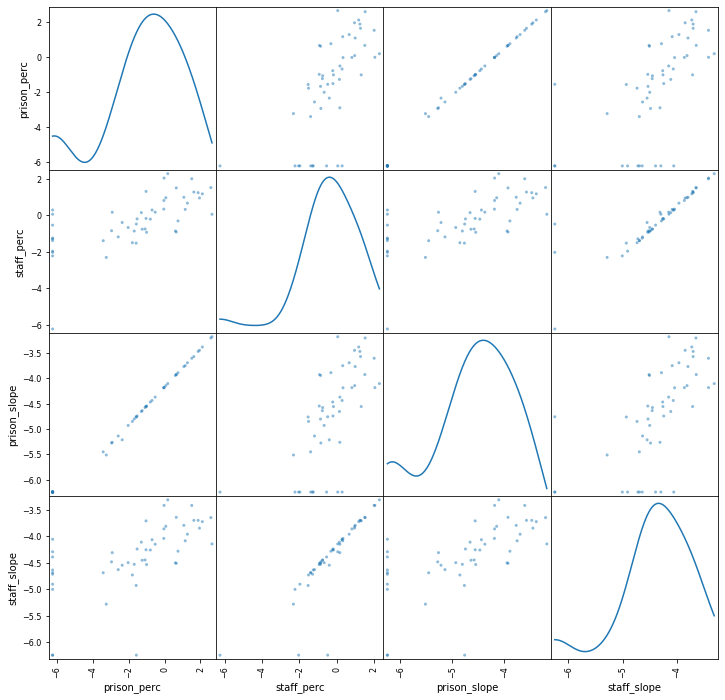

In [21]:
from pandas.plotting import scatter_matrix

y_variables = pd.DataFrame({
    "prison_perc": y_prison_perc,
    "staff_perc": y_staff_perc,
    "prison_slope": y_prison_slope,
    "staff_slope": y_staff_slope
})
scatter_matrix(y_variables, figsize=(12,12), diagonal='kde')
plt.show()

In [22]:
for x_col in X.columns:
    if x_col == 'const':
        continue
    X[x_col] = (X[x_col] - X[x_col].mean()) / X[x_col].std()

In [23]:
linear_regression1 = sm.OLS(y_prison_perc,X)
res1 = linear_regression1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.053
Date:                Fri, 15 May 2020   Prob (F-statistic):              0.435
Time:                        21:58:02   Log-Likelihood:                -110.66
No. Observations:                  50   AIC:                             257.3
Df Residuals:                      32   BIC:                             291.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.5679      0.391     -4.008      0.000      -2.365      -0.771
webpage                       -0.3345      0.517     -0.647      0.522      -1.388       0.719
tracker                        0.5439      0.494      1.101      0.279      -0.463       1.550
visitation_suspended          -1.7637      1.818     -0.970      0.339      -5.466       1.939
legal_visitation_permitted    -1.9609      1.781     -1.101      0.279      -5.589       1.667
telephone_change              -0.0806      0.600     -0.134      0.894      -1.304       1.143
video_change                   0.2837      0.456      0.622      0.538      -0.645       1.212
additional_change              0.2868      0.460      0.623      0.538      -0.651       1.225
Increased_hygiene              0.8016      0.513      1.562      0.128      -0.244       1.847
Screening_employees           -0.3954      0.484     -0.818      0.420      -1.380       0.590
Screening_admissions           0.2376      0.553      0.430      0.670      -0.888       1.363
Suspended_Transfers            0.1581      0.482      0.328      0.745      -0.824       1.140
Mandatory_isolation            0.3049      0.601      0.507      0.615      -0.919       1.529
Suspension_medical_copays      0.1270      0.442      0.287      0.776      -0.773       1.027
Expedited_parole              -0.7383      0.490     -1.507      0.142      -1.736       0.260
Reducing_staff                 0.0441      0.459      0.096      0.924      -0.891       0.979
System_quarantine              0.1844      0.489      0.377      0.708      -0.811       1.180
Lockdown_facilities            0.2287      0.473      0.483      0.632      -0.736       1.193
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.580
Skew:                           0.027   Prob(JB):                        0.748
Kurtosis:                       2.475   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
X.drop(columns="const", inplace=True)
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(X, y_staff_perc)
pd.DataFrame({"feature": X.columns, "coef": clf.coef_})

,feature,coef
0,webpage,-0.000000
1,tracker,0.000000
2,visitation_suspended,0.000000
3,legal_visitation_permitted,-0.142154
4,telephone_change,-0.000000
5,video_change,0.143845
6,additional_change,0.019175
7,Increased_hygiene,0.165371
8,Screening_employees,-0.105437
9,Screening_admissions,-0.000000


## 2. Decision Tree

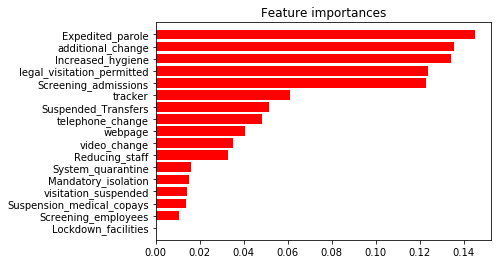

In [25]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor

# Build a forest and compute the feature importances
forest = DecisionTreeRegressor()

forest.fit(X_data, y_prison_perc)
importances = forest.feature_importances_

indices = np.argsort(importances)
label = X_data.columns[indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_data.shape[1]), importances[indices],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_data.shape[1]), label)
plt.ylim([-1, X_data.shape[1]])
plt.show()